# Model Hyperparameter Tuning Task

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.1 MB/s eta 0:00:00


## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

## Load and Prepare the Dataset

In [4]:
data = load_breast_cancer()
X = data.data
y = data.target

## Standardizing Features to Improve Model Performance

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Split data into training and testing sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train a Baseline Model (Random Forest)

In [7]:
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Make predictions

In [8]:
y_pred_baseline = baseline_model.predict(X_test)

## Evaluate baseline model

In [9]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print("Baseline Accuracy (Random Forest):", baseline_accuracy)
print(classification_report(y_test, y_pred_baseline))

Baseline Accuracy (Random Forest): 0.9649122807017544
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



## Hyperparameter Tuning Using Grid Search for XGBoost

In [10]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:54:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

## Get best parameters

In [11]:
best_params_grid = grid_search.best_params_
print("Best Hyperparameters (Grid Search):", best_params_grid)

Best Hyperparameters (Grid Search): {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200}


## Train XGBoost with the Best Parameters from Grid Search

In [12]:
xgb_tuned_grid = XGBClassifier(**best_params_grid, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_tuned_grid.fit(X_train, y_train)

y_pred_tuned_grid = xgb_tuned_grid.predict(X_test)

tuned_accuracy_grid = accuracy_score(y_test, y_pred_tuned_grid)
print("Tuned Model Accuracy (Grid Search - XGBoost):", tuned_accuracy_grid)
print(classification_report(y_test, y_pred_tuned_grid))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned Model Accuracy (Grid Search - XGBoost): 0.9824561403508771
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## Hyperparameter Tuning Using Optuna

In [13]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 15, step=2)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_loguniform("gamma", 0.01, 1.0)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

best_params_optuna = study.best_params
print("Best Hyperparameters (Optuna):", best_params_optuna)

[I 2025-03-28 22:58:45,315] A new study created in memory with name: no-name-e346acab-a84f-46f7-b7bf-52e434cee29c
<ipython-input-13-285015037840>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
<ipython-input-13-285015037840>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 0.01, 1.0)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:58:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWar

Best Hyperparameters (Optuna): {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1964653961888904, 'min_child_weight': 4, 'gamma': 0.12763700665885186}


## Train XGBoost with the Best Parameters from Optuna

In [14]:
xgb_tuned_optuna = XGBClassifier(**best_params_optuna, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_tuned_optuna.fit(X_train, y_train)

y_pred_tuned_optuna = xgb_tuned_optuna.predict(X_test)

tuned_accuracy_optuna = accuracy_score(y_test, y_pred_tuned_optuna)
print("Tuned Model Accuracy (Optuna - XGBoost):", tuned_accuracy_optuna)
print(classification_report(y_test, y_pred_tuned_optuna))

Tuned Model Accuracy (Optuna - XGBoost): 0.9736842105263158
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Compare Before vs After Tuning

In [15]:
print(f"Baseline Accuracy (Random Forest): {baseline_accuracy:.4f}")
print(f"Tuned Accuracy (Grid Search - XGBoost): {tuned_accuracy_grid:.4f}")
print(f"Tuned Accuracy (Optuna - XGBoost): {tuned_accuracy_optuna:.4f}")

Baseline Accuracy (Random Forest): 0.9649
Tuned Accuracy (Grid Search - XGBoost): 0.9825
Tuned Accuracy (Optuna - XGBoost): 0.9737


## Feature Importance Visualization

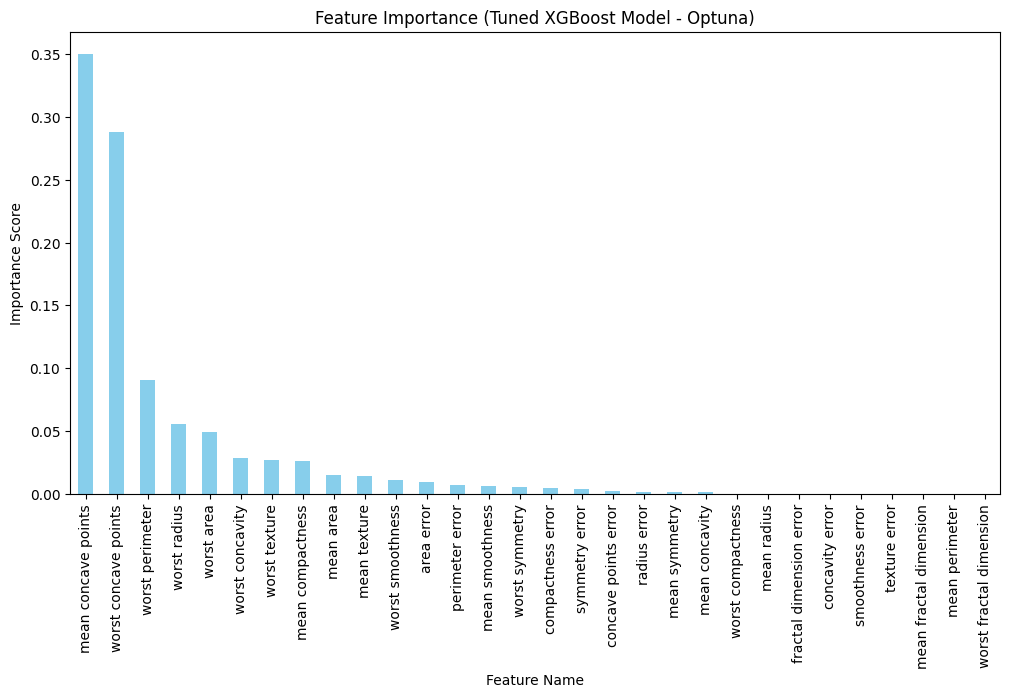

In [16]:
feature_importance = pd.Series(xgb_tuned_optuna.feature_importances_, index=data.feature_names)
plt.figure(figsize=(12, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Feature Importance (Tuned XGBoost Model - Optuna)")
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.show()

## Confusion Matrix Visualization

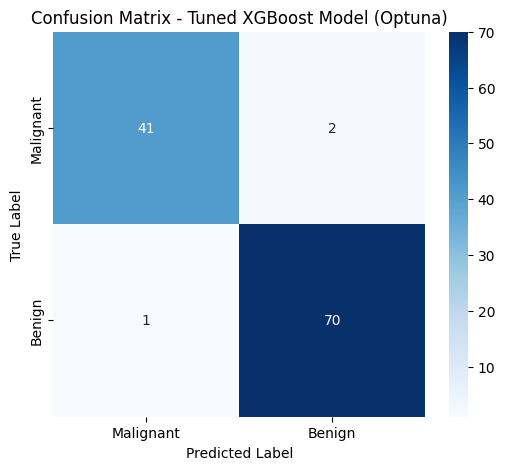

In [17]:
cm = confusion_matrix(y_test, y_pred_tuned_optuna)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tuned XGBoost Model (Optuna)")
plt.show()

## Summary of Findings

In [18]:
print("\n📌 SUMMARY OF FINDINGS")
print("1️⃣ Standardized Features for Better Model Performance")
print("2️⃣ Compared Hyperparameter Tuning Methods: Grid Search vs. Optuna")
print("3️⃣ Best Parameters for Each Tuning Method Displayed")
print("4️⃣ Accuracy Improvement: {:.4f} (RF) → {:.4f} (Grid Search) → {:.4f} (Optuna)".format(baseline_accuracy, tuned_accuracy_grid, tuned_accuracy_optuna))
print("✔ XGBoost with optimized hyperparameters performed better than the baseline model!")


📌 SUMMARY OF FINDINGS
1️⃣ Standardized Features for Better Model Performance
2️⃣ Compared Hyperparameter Tuning Methods: Grid Search vs. Optuna
3️⃣ Best Parameters for Each Tuning Method Displayed
4️⃣ Accuracy Improvement: 0.9649 (RF) → 0.9825 (Grid Search) → 0.9737 (Optuna)
✔ XGBoost with optimized hyperparameters performed better than the baseline model!
